# On device Training Little

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

## Model Setup

In [ ]:
interpreter = tf.lite.Interpreter(model_path="emnist_litert_model_FIXED.tflite")
interpreter.allocate_tensors()
train_fn = interpreter.get_signature_runner("train")
infer_fn = interpreter.get_signature_runner("infer")

c:\Users\arnau\Uni\Master\1B UniTn\IoT\Project\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


## Dataset Setup

In [3]:
(ds_train_digits, ds_test_digits), _ = tfds.load(
    'emnist/digits',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

BATCH_SIZE = 64

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Preprocess and convert to list
train_digits = list(ds_train_digits.map(preprocess).take(500))
test_digits = list(ds_test_digits.map(preprocess).take(128))

### Prepare DS and Model

In [4]:
x_test = tf.stack([img for img, _ in test_digits])
y_test = tf.stack([lbl for _, lbl in test_digits])

In [5]:
def evaluate():
    print(f"X test shape: {x_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    preds = infer_fn(x=x_test)['probs']
    y_pred = tf.argmax(preds, axis=1)
    acc = tf.reduce_mean(tf.cast(y_pred == y_test, tf.float32)).numpy()
    return acc

## "On-Device" Training

In [6]:
import numpy as np

# Use NumPy arrays instead of tf.Tensors
dummy_x_np = np.zeros((1, 28, 28, 1), dtype=np.float32)
dummy_y_np = np.zeros((1,), dtype=np.int32)

_ = train_fn(x=dummy_x_np, y=dummy_y_np)  # ✅ should initialize without error


RuntimeError: tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 26 (READ_VARIABLE) failed to invoke.

In [18]:
# Print to verify input shape
dummy_x = tf.zeros([1, 28, 28, 1], dtype=tf.float32)
dummy_y = tf.zeros([1], dtype=tf.int32)

print("Dummy X shape:", dummy_x.shape)
print("Dummy Y shape:", dummy_y.shape)


_ = train_fn(
    x=np.zeros((1, 28, 28, 1), dtype=np.float32),
    y=np.zeros((1,), dtype=np.int32)
)



Dummy X shape: (1, 28, 28, 1)
Dummy Y shape: (1,)


RuntimeError: tensorflow/lite/kernels/conv.cc:345 input->dims->size != 4 (5 != 4)Node number 17 (CONV_2D) failed to prepare.tensorflow/lite/kernels/conv.cc:345 input->dims->size != 4 (5 != 4)Node number 17 (CONV_2D) failed to prepare.tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 8 (READ_VARIABLE) failed to invoke.tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 8 (READ_VARIABLE) failed to invoke.tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 8 (READ_VARIABLE) failed to invoke.tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 26 (READ_VARIABLE) failed to invoke.tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 26 (READ_VARIABLE) failed to invoke.tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 26 (READ_VARIABLE) failed to invoke.tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 26 (READ_VARIABLE) failed to invoke.

In [14]:
accuracies = [evaluate()]
losses = [0.0]
image_counts = [0]

batch_size = 100
for i in range(0, len(train_digits), batch_size):
    batch = train_digits[i:i+batch_size]
    x_batch = tf.stack([img for img, _ in batch])
    y_batch = tf.stack([lbl for _, lbl in batch])

    print(f"[INFO] Training on samples {i} to {i+batch_size}")
    result = train_fn(x=x_batch, y=y_batch)
    loss = result['loss']
    acc = evaluate()

    print(f"[RESULT] Loss: {loss:.4f} | Accuracy: {acc:.4f}")
    accuracies.append(acc)
    losses.append(loss)
    image_counts.append(i + batch_size)

X test shape: (128, 28, 28, 1)
Y test shape: (128,)


RuntimeError: tensorflow/lite/kernels/conv.cc:345 input->dims->size != 4 (5 != 4)Node number 17 (CONV_2D) failed to prepare.tensorflow/lite/kernels/conv.cc:345 input->dims->size != 4 (5 != 4)Node number 17 (CONV_2D) failed to prepare.tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 8 (READ_VARIABLE) failed to invoke.tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 8 (READ_VARIABLE) failed to invoke.tensorflow/lite/kernels/read_variable.cc:67 variable != nullptr was not true.Node number 8 (READ_VARIABLE) failed to invoke.

## Evaluation

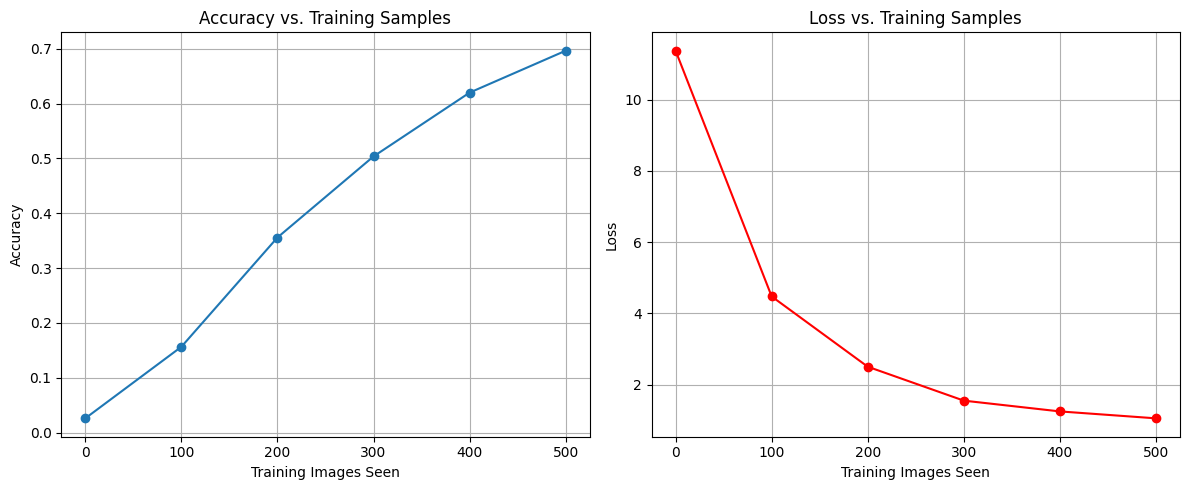

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(image_counts, accuracies, marker='o')
plt.title("Accuracy vs Training Samples")
plt.xlabel("Training Samples Seen")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(image_counts[1:], losses[1:], marker='o', color='red')
plt.title("Loss vs Training Samples")
plt.xlabel("Training Samples Seen")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

## OPTIONAL: SAVE NEW MODEL

In [ ]:
# model.save("emnist_letters_retrained_digits.keras")